# T022 - Ligand-based screening: Neural networks

Developed in the CADD seminar 2020, Volkamer Lab, Charité/FU Berlin 

Authors : 
- Sakshi Misra, [Volkamer lab](https://volkamerlab.org), Charité
- Talia B. Kimber, [Volkamer lab](https://volkamerlab.org), Charité
- Prof. Dr. Andrea Volkamer, [Volkamer lab](https://volkamerlab.org), Charité

## Aim of this talktorial

In this talktorial, we will get familiar with the mechanism of the artificial neural network. Furthermore, we will learn how to build a simple two layer neural network model and use it to predict the PIC50 values of unknown compounds against our target of interest (EGFR).

### Contents in *Theory*

- Basic Background
   - EGFR
   - IC50
- Molecule encoding  
- What is a neural network? 
- Why neural network ?
- Basic structure of a neural network
- Types of neural networks
- Main algorithms in a neural network
- Activation function
    - Types of activation function

### Contents in *Practical*

- Load molecules and visualize the dataframe
- Data Preparation : Molecule encoding
- Neural network


### References

-
-
-



## Theory

### Biological background

#### EGFR

Epidermal growth factor receptor (EGFR) is a transmembrane protein activated by binding of its specific ligands and it included in the cell growth process. It is also be found at high levels on some types of cancer cells, which causes these cells to grow and divide quickly so one of the approaches in treatment the cancer is inhibiting EGFR receptor. To determine the efficacy of drugs that can inhibit EGFR we measure IC50 (PIC50) to the drug and in this project, we will build model to predict the PIC50 of drugs from its smiles and fingerprint.

#### Compound activity measures (IC50)

IC50 is half maximal concentration of inhibitory drug to inhibit the activity of specific enzyme and in our case the Epidermal growth factor receptor as its Inhibition helps in slow down or stop cancer cell growth. Using **pIC50** (the negative log of the IC50 value) because it is easy for interpretation than IC50 and common for potency of compounds 

### Data aquisition and preparation

#### Molecular encoding

Molecular fingerprints represent the chemical structures in bit strings form as each position mean the presence (1) or absence (0) of chemical features as defined in the design of the fingerprint.one of common fingerprint is molecular ACCess System (MACCS) fingerprints (MACCS Keys) which are 166 bits structural key descriptors in which each bit is associated with a SMARTS pattern  which is the same as smiles with some extensions and flexibility [SMARTS :A Language for Describing Molecular Patterns](https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html)
[RDKit documentation: MACCS keys](http://rdkit.org/docs/source/rdkit.Chem.MACCSkeys.html)

### What is a neural network?

Neural networks, also known as artificial neural networks (ANNs) are a subset of machine learning algorithms. Their name and structure are inspired by the human brain, mimicking the way that biological neurons transfers signal to one another.
Artificial neural networks (ANNs) are comprised of a node layers, containing an input layer, one or more hidden layers, and an output layer. Each node, or artificial neuron, connects to another and has an associated weight and threshold


![Neural network](images/neural_network.png)

*Figure 1*: 



### Why neural networks?

### Basic structure of a neural network

Neural network consist of three main layers:
1. Input layers which are equal to the number of features in input data 
2. Hidden layers in the middle between the input and output layers 
3. Output layer are the observations of input data.


The connection between each layer depend mainly on the output of previous connecting neurons from the previous layer, weights of connecting edges between neurons and the activation function in neuron itself, which all give a new output to the forward neurons in next layer. 

### Types of neural networks

### Main algorithms 

The main algorithms for neural network: forward, back propagation, optimization function (gradient descent).
1. **Forward propagation**: It takes all first assumption of weights that affect on node with the output values of nodes from previous layer then add them to be as input to the node and with the activation function of this node , it gives output which can be used with the weights of the next edges as input to the forward nodes in next layer.

2. **Back propagation**: It starts from the last layer (output layer) and go backward until input layer. at the output layer , nodes have values from forward propagation but these values are different from the actual values that are given to model so with specific loss function for example mean squared error **as in this project** calculate the loss function between the actual and predicted values in nodes in output layer . After that according to the value of loss function  back propagation try to change the weights of edges to reach optimum solution and this occur by optimization function.

3. **Gradient descent (optimization function)**: It tries to guide the algorithm how can reduce the loss function to reach the global solution by changing the values of weights in backward process from the weights of hidden layer to weights of input layer then repeat the forward propagation again and so on until convergence  the global solution and lowest value loss cost. there are more than type of optimization function but we use here 'ADAM' as it Computationally efficient and Little memory requirements. we can also say briefly that the mathematical overview  of gradient descent depend mainly on: 
  * At lowest point (lowest cost function ) of curve , the differential equation of function at this point = zero
  * chain rule to get the partial differential equation ( relation between each weight and the final loss function)


**Types of loss function**:
1. mean squared error : used mainly in regression problem as in this project 
2. cross entropy: used in case of classification 

### Activation function

There is no definitive guide for which activation function works best on specific problems. It's a trial and error process where one should try different set of functions and see which one works best on the problem at hand. We'll cover 4 of the most commonly used activation functions:

- **Sigmoid function (σ)**: g(z)=11+e−z. It's recommended to be used only on the output layer so that we can easily interpret the output as probabilities since it has restricted output between 0 and 1. One of the main disadvantages for using sigmoid function on hidden layers is that the gradient is very close to zero over a large portion of its domain which makes it slow and harder for the learning algorithm to learn.
- **Hyperbolic Tangent function**: g(z)=ez−e−zez+e−z. It's superior to sigmoid function in which the mean of its output is very close to zero, which in other words center the output of the activation units around zero and make the range of values very small which means faster to learn. The disadvantage that it shares with sigmoid function is that the gradient is very small on good portion of the domain.
- **Rectified Linear Unit (ReLU)**: g(z)=max{0,z}. The models that are close to linear are easy to optimize. Since ReLU shares a lot of the properties of linear functions, it tends to work well on most of the problems. The only issue is that the derivative is not defined at z=0, which we can overcome by assigning the derivative to 0 at z=0. However, this means that for z≤0 the gradient is zero and again can't learn.
- **Leaky Rectified Linear Unit**: g(z)=max{α∗z,z}. It overcomes the zero gradient issue from ReLU and assigns α which is a small value for z≤0.

ReLU is the most common used activation function.

We will implement the above activation functions and draw a graph for each one to make it easier to see the domain and range of each function in the practical section below.

## Practical

In [1]:
from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Draw
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# Neural network specific libraries
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline
from pathlib import Path

# Silence some expected warnings
filterwarnings("ignore")

### Load molecules and visualize the dataframe

Let's start by loading our data which is the subset of ChEMBL dataset and visulaize the dataframe, the importannt columns in the dataframe are:

- CHEMBL-ID
- SMILES string of the corresponding compound
- Measured affinity: pIC50

In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

df = pd.read_csv(DATA/'CHEMBL25_activities_EGFR.csv',
                 lineterminator='\n') # NBVAL_CHECK_OUTPUT

In [3]:
# Check the dimension and missing value of the data 
print("Shape of dataframe : ", df.shape) 
df.info()

# Look at head
df.head() # NBVAL_CHECK_OUTPUT

Shape of dataframe :  (3906, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3906 entries, 0 to 3905
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        3906 non-null   int64  
 1   chembl_id         3906 non-null   object 
 2   IC50              3906 non-null   float64
 3   units             3906 non-null   object 
 4   canonical_smiles  3906 non-null   object 
            3906 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 183.2+ KB


,Unnamed: 0,chembl_id,IC50,units,canonical_smiles,pIC50\r
0,1777,CHEMBL207869,77.0,nM,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,7.113509
1,5785,CHEMBL3940060,330.0,nM,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,6.481486
2,6373,CHEMBL3678951,1.0,nM,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,9.000000
3,2442,CHEMBL504034,40.0,nM,Clc1c(OCc2cc(F)ccc2)ccc(Nc2ncnc3c2sc(C#C[C@H]2...,7.397940
4,1084,CHEMBL158797,43000.0,nM,S(Sc1n(C)c2c(c1C(=O)NCC(O)CO)cccc2)c1n(C)c2c(c...,4.366531


In [4]:
# Keep only the columns we want
chembl_df = df[["chembl_id", "canonical_smiles", "pIC50\r"]]
chembl_df.head()
# NBVAL_CHECK_OUTPUT

,chembl_id,canonical_smiles,pIC50\r
0,CHEMBL207869,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,7.113509
1,CHEMBL3940060,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,6.481486
2,CHEMBL3678951,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,9.000000
3,CHEMBL504034,Clc1c(OCc2cc(F)ccc2)ccc(Nc2ncnc3c2sc(C#C[C@H]2...,7.397940
4,CHEMBL158797,S(Sc1n(C)c2c(c1C(=O)NCC(O)CO)cccc2)c1n(C)c2c(c...,4.366531


### Data Preparation

#### Molecule encoding
Now we use already defined function `smiles_to_fp` from Talktorial **T007** to generate fingerprints from SMILES. 

It will generate fingerprints of the molecules TODO

In [5]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [6]:
# convert all SMILES strings to MACC fingerprints
fingerprints_df = pd.DataFrame([smiles_to_fp(smile) for smile in chembl_df['canonical_smiles']])
fingerprints_df.shape

(3906, 167)

In [7]:
fingerprints_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,0,1,0


Define X and y

In [8]:
X = fingerprints_df
y = chembl_df[['pIC50\r']]

### Implementation of aboved defined activation functions 

Now we will define the activation functions which were discussed in the theory sections.

In [41]:
# Define activation functions that can be used in forward propagation
def sigmoid(Z):
    """
    Computes the sigmoid of Z element-wise.

    Parameters
    ----------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
    Z : array
        output of affine transformation.
    """
    A = 1 / (1 + np.exp(-Z))

    return A, Z


def tanh(Z):
    """
    Computes the Hyperbolic Tagent of Z element-wise.

    Parameters
    ----------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
    Z : array
        output of affine transformation.
    """
    A = np.tanh(Z)

    return A, Z


def relu(Z):
    """
    Computes the Rectified Linear Unit (ReLU) element-wise.

    Parameters
    ----------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
    Z : array
        output of affine transformation.
    """
    A = np.maximum(0, Z)

    return A, Z


def leaky_relu(Z):
    """
    Computes Leaky Rectified Linear Unit element-wise.

    Parameters
    ----------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
    Z : array
        output of affine transformation.
    """
    A = np.maximum(0.1 * Z, Z)

    return A, Z

After defining the Plotting the activation function

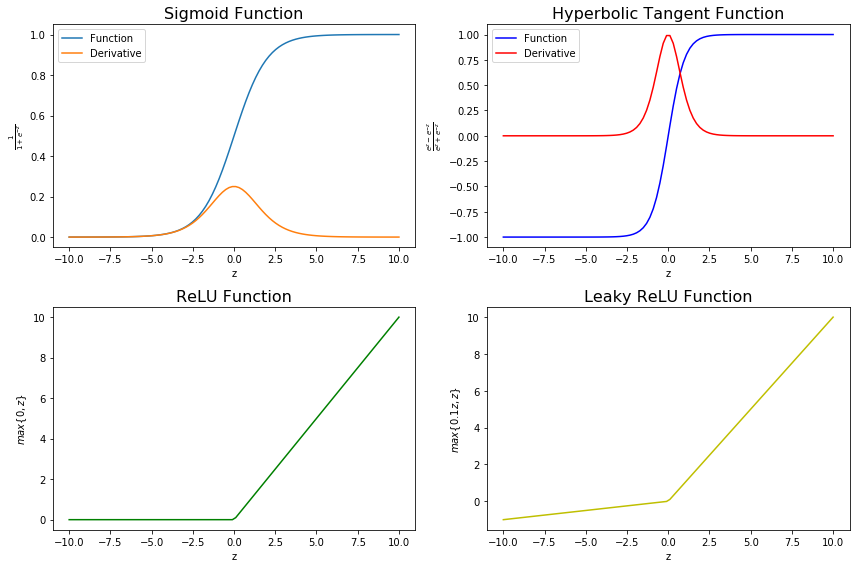

In [10]:
# Plot the 4 activation functions
z = np.linspace(-10, 10, 100)

# Computes post-activation outputs
A_sigmoid, z = sigmoid(z)
A_tanh, z = tanh(z)
A_relu, z = relu(z)
A_leaky_relu, z = leaky_relu(z)

# Plot sigmoid
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(z, A_sigmoid, label = "Function")
plt.plot(z, A_sigmoid * (1 - A_sigmoid), label = "Derivative")
plt.legend(loc = "upper left")
plt.xlabel("z")
plt.ylabel(r"$\frac{1}{1 + e^{-z}}$")
plt.title("Sigmoid Function", fontsize = 16)

# Plot tanh
plt.subplot(2, 2, 2)
plt.plot(z, A_tanh, 'b', label = "Function")
plt.plot(z, 1 - np.square(A_tanh), 'r',label = "Derivative")
plt.legend(loc = "upper left")
plt.xlabel("z")
plt.ylabel(r"$\frac{e^z - e^{-z}}{e^z + e^{-z}}$")
plt.title("Hyperbolic Tangent Function", fontsize = 16)

# plot relu
plt.subplot(2, 2, 3)
plt.plot(z, A_relu, 'g')
plt.xlabel("z")
plt.ylabel(r"$max\{0, z\}$")
plt.title("ReLU Function", fontsize = 16)

# plot leaky relu
plt.subplot(2, 2, 4)
plt.plot(z, A_leaky_relu, 'y')
plt.xlabel("z")
plt.ylabel(r"$max\{0.1z, z\}$")
plt.title("Leaky ReLU Function", fontsize = 16)
plt.tight_layout();

### Neural network model

In [11]:
X = np.array(fingerprints_df)
X.shape

(3906, 167)

In [33]:
# example dataset to check 
x = [[1.0, 2.0, 3.0, 2.5],
     [2.0, 3.0, 4.0, 5.0],
     [4.0, 5.0, 6.0, 7.0]]

In [38]:
def forward_pass(n_inputs, n_neurons):
        weights = 0.10 * np.random.randn(n_inputs, n_inputs)
        biases = np.zeros((1, n_neurons))
        output = np.dot(n_inputs, weights) + self.biases

In [34]:
# create forward function

class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.10 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases


class Activation_ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)


        
layer1 = Layer_Dense(4, 5)
layer2 = Layer_Dense(5, 1)


activation1 = Activation_ReLU()
activation2 = Activation_ReLU()

layer1.forward(x)
layer1.forward(layer1.output)

activation1.foward(layer1.output)
activation2.foward(layer2.output)
print(activation2.output)

ValueError: shapes (3,5) and (4,5) not aligned: 5 (dim 1) != 4 (dim 0)

Neural network model using keras

Now we will use tensorflow to define our neural network model

In [14]:
def NN_model(hidden1, hidden2):
    """
    creating neural network from two hidden layer
    using relu as activation function in two hidden layer
    and linear in the output layer

    parameters
    ----------
    hidden1 : Int
              number of neuons in first hidden layer

    hidden2: Int
             number of neuons in second hidden layer
    Returns
    --------
    model fully connected neural network model with two hidden layer
    """

    model = Sequential()
    # first hidden layer
    model.add(Dense(hidden1, activation='relu', name="layer1"))
    # dropout prevent overfitting
    Dropout(.5)
    # second headden layer
    model.add(Dense(hidden2, activation='relu', name="layer2"))
    Dropout(.5)
    # output layer
    model.add(Dense(1, activation='linear', name="layer3"))

    # compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'])
    return model

### Choose the most appropriate batch sizes 

In [15]:
# Split the data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

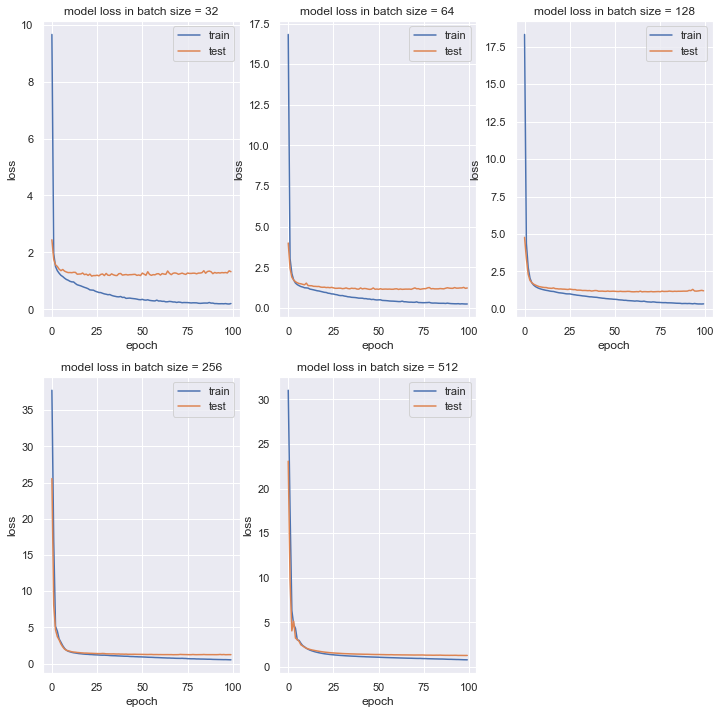

In [16]:
# trying different batch sizes
batch_sizes = [32, 64, 128, 256, 512]

# size of figure
fig = plt.figure(figsize=(12, 12))
sns.set(color_codes=True)
for i in range(1, 6):

    fig.add_subplot(2, 3, i)

    model = NN_model(64, 32)
    history = model.fit(X_train, y_train, batch_size=batch_sizes[i-1],
                        validation_data=(X_test, y_test),
                        verbose=0, epochs=100)

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend(['train', 'test'], loc='upper right')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('model loss in batch size = '+str(batch_sizes[i-1]))
plt.show()

### Training the model

In [17]:
# creat new model

#model = NN_model(64, 32)

# save the model
filepath = "weights_CV.best.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1,
                             save_best_only=True, mode='min')
callbacks_list = [checkpoint]
model.fit(X, y, epochs=100, batch_size=512,
          callbacks=callbacks_list, verbose=0)

score = model.evaluate(X, y)
print(f'score:{score}')


Epoch 00001: loss improved from inf to 28.97996, saving model to weights_CV.best.hdf5

Epoch 00002: loss improved from 28.97996 to 10.09608, saving model to weights_CV.best.hdf5

Epoch 00003: loss improved from 10.09608 to 4.91296, saving model to weights_CV.best.hdf5

Epoch 00004: loss improved from 4.91296 to 4.05455, saving model to weights_CV.best.hdf5

Epoch 00005: loss improved from 4.05455 to 3.19713, saving model to weights_CV.best.hdf5

Epoch 00006: loss improved from 3.19713 to 2.76097, saving model to weights_CV.best.hdf5

Epoch 00007: loss improved from 2.76097 to 2.44005, saving model to weights_CV.best.hdf5

Epoch 00008: loss improved from 2.44005 to 2.16572, saving model to weights_CV.best.hdf5

Epoch 00009: loss improved from 2.16572 to 1.96937, saving model to weights_CV.best.hdf5

Epoch 00010: loss improved from 1.96937 to 1.85136, saving model to weights_CV.best.hdf5

Epoch 00011: loss improved from 1.85136 to 1.74150, saving model to weights_CV.best.hdf5

Epoch 000

### Loading the test data (EGFR_test_set.csv)

In [18]:
test_df = pd.read_csv(DATA/'test.csv',
                 lineterminator='\n') # NBVAL_CHECK_OUTPUT

test_df.head()

,id,canonical_smiles\r
0,1,S(Cc1c([O-])c(OC)cc(/C=C(\C#N)/C(=O)N)c1)c1ccc...
1,2,S=C(N)N1C(c2ccc(OC)cc2)CC(c2cc(C)c(C)cc2)=N1\r
2,3,Clc1c(O)cc(-c2nn(C(C)C)c3ncnc(N)c23)cc1\r
3,4,O=C(/C=C/CN1CC[NH+](C)CC1)N1Cc2sc3ncnc(N[C@H](...
4,5,S(=O)(=O)(NC(=O)Cn1c(C)ncc1[N+](=O)[O-])c1ccc(...


### Prediction  of pic50 values of molecules in test data

In [25]:
# convert all smiles in test file to maacc keys
maccs_test_df = pd.DataFrame([smiles_to_fp(smile) for smile in test_df['canonical_smiles\r']])
maccs_test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0


In [21]:
# prediction on test data
pred = model.predict(maccs_test_df)

predicted_pic50 = pd.DataFrame(pred, columns=['Predicted PIC50 values'])
predicted_pic50_df = test_df.join(predicted_pic50)

predicted_pic50_df.head(3)

,id,canonical_smiles\r,Predicted PIC50 values
0,1,S(Cc1c([O-])c(OC)cc(/C=C(\C#N)/C(=O)N)c1)c1ccc...,5.582004
1,2,S=C(N)N1C(c2ccc(OC)cc2)CC(c2cc(C)c(C)cc2)=N1\r,5.046647
2,3,Clc1c(O)cc(-c2nn(C(C)C)c3ncnc(N)c23)cc1\r,5.316544


In [22]:
# model evaluation on test data 
score = model.evaluate(maccs_test_df, pred)
print(f'score:{score}')

2/2 [==============================] - 0s 4ms/step - loss: 2.4727e-13 - mse: 2.4727e-13 - mae: 3.7750e-07
score:[2.47268866623504e-13, 2.47268866623504e-13, 3.774960930513771e-07]


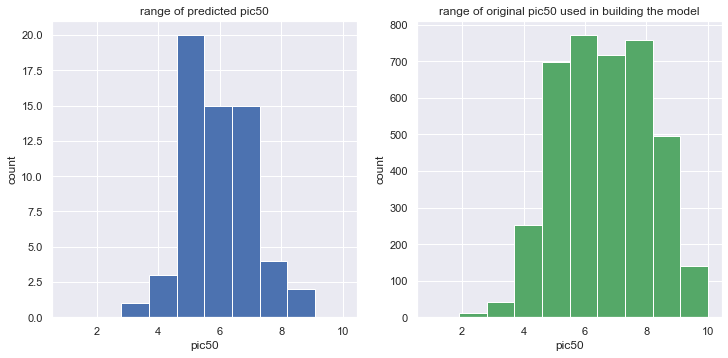

In [23]:
# Histogram to the distribution of the predected pic50 in test file
plt.figure(figsize=(12, 12))
sns.set(color_codes=True)

plt.subplot(221)
plt.hist(predicted_pic50_df["Predicted PIC50 values"],
         facecolor='b', histtype='barstacked', range=(1, 10))
plt.xlabel('pic50')
plt.ylabel('count')
plt.title('range of predicted pic50')

plt.subplot(222)
plt.hist(chembl_df["pIC50\r"], facecolor='g', range=(1, 10), bins=10)
plt.xlabel('pic50')
plt.ylabel('count')
plt.title('range of original pic50 used in building the model')
plt.show()
sns.set()

## Discussion

### Quiz